# pyfabric example 02: fabric tensor of trabecular bone of the proximal femur - comparison of scans with different spatial resolution

Created on:  25.10.2021 <br />
Last update: 09.04.2023 <br />

![](2000L_crop_imgaussfilt_101micron_uint8_YZ_fabric.png)

## Configuration

In [1]:
import os
import sys
# sys.path.insert(0, os.path.abspath('../'))
sys.path.append('/home/gianthk/PycharmProjects/recon_utils')
sys.path.append('/home/gianthk/PycharmProjects/pyfabric')

# work_folder = '/media/gianthk/My Passport'
work_folder = '/home/gianthk'

In [2]:
import pyfabric
import recon_utils as ru

astropy module not found
olefile module not found


In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import skimage.io as io
from skimage.filters import threshold_multiotsu
from skimage import morphology
from skimage.measure import label, regionprops, regionprops_table
import pandas as pd
import heapq
import SimpleITK as sitk

# from ipywidgets import interact, fixed

# import imageio

# from scipy import ndimage, misc
# from skimage.filters import threshold_otsu, gaussian

In [4]:
matplotlib.rcParams['figure.dpi'] = 300

font = {'weight' : 'normal',
        'size'   : 6}

plt.rc('font', **font)

In [5]:
%%html
<style>
table {float:left}
</style>

#### Read input data

In [6]:
input_file_HR = work_folder + '/Data/TacoSound/XtremeCT-II/00_resampled_data/2019_L/C0001524.mhd'
input_dir_QCT_DCM = work_folder + '/Data/TacoSound/QCT/QCTFEMUR_2019L/Q_CT_DIAGBILANZ_HR_0003'
input_file_QCT = work_folder + '/Data/TacoSound/QCT/QCTFEMUR_2019L/slices/slice_0000.tif'

In [7]:
# Read 3D data
data_3D_QCT = np.flip(ru.read_tiff_stack(input_file_QCT), 0)
vs = [0.3005, 0.293, 0.293] # [Z, Y, X][mm]

# data_3D_QCT = imageio.v2.volread(input_dir_QCT, format='.dcm')

In [ ]:
# Inspect dataset
ru.plot_midplanes(data_3D_QCT)
plt.show()

Inspect the dataset with [itkwidgets](https://github.com/InsightSoftwareConsortium/itkwidgets)

In [8]:
data_3D = io.imread(input_file_HR, plugin='simpleitk')

In [ ]:
# Inspect dataset
ru.plot_midplanes(data_3D)
plt.show()

### Select cement markers
#### Segment markers and bone with multi otsu threshold
We add an image opening step to remove spurious voxels

In [9]:
ts = threshold_multiotsu(data_3D_QCT)
data_3D_QCT_BW = morphology.binary_opening(data_3D_QCT > ts[1])

In [ ]:
ru.plot_projections(data_3D_QCT_BW[0:120,:,:])
plt.show()

In [10]:
def dist_table(coors):
    n_points = coors.shape[0]
    disttab = np.zeros([n_points, n_points])
    for i in range(n_points):
        for j in range(n_points):
            disttab[i,j] = np.linalg.norm(coors[i,:]-coors[j,:])
    return disttab

In [11]:
def markers_coors(BWimage):
    # get coordinates of 5 cement markers from binary image
    
    label_img = label(BWimage)
    
    props = regionprops_table(label_img, properties=('centroid','area'))
    
    props_df = pd.DataFrame(props)
    
    props_df.sort_values('area', ascending=False, inplace=True)
    props_df.reset_index(drop=True, inplace=True)
    
    markers_df = props_df[1:6]
    centroids = markers_df[['centroid-0', 'centroid-1', 'centroid-2']].to_numpy()
    
    distances = dist_table(centroids)
    
    for row in distances:
        row.sort()
        
    sum2dist = np.sum(distances[:,0:3], axis=1).tolist()
    min_3_dists = heapq.nsmallest(3,sum2dist)
    
    count = 0
    marker_id = np.zeros(3)
    for dist in min_3_dists:
        marker_id[count] = sum2dist.index(dist)
        count = count + 1

    M5_id = int(marker_id[0])
    M1_id = int(marker_id[1])
    M2_id = int(marker_id[2])
    
    
    sum3dist = np.sum(distances[:,0:4], axis=1).tolist()
    max_2_dists = heapq.nlargest(2,sum3dist)

    count = 0
    marker_id = np.zeros(2)
    for dist in max_2_dists:
        marker_id[count] = sum3dist.index(dist)
        count = count + 1

    M3_id = int(marker_id[0])
    M4_id = int(marker_id[1])
    
    marker_coors = np.zeros([5,3])
    marker_coors[0,:] = centroids[M1_id,:]
    marker_coors[1,:] = centroids[M2_id,:]
    marker_coors[2,:] = centroids[M3_id,:]
    marker_coors[3,:] = centroids[M4_id,:]
    marker_coors[4,:] = centroids[M5_id,:]
    
    return marker_coors

In [77]:
A = np.array([[1, 2],
              [3, 4]])
print(np.matmul(A,A))

[[ 7 10]
 [15 22]]


In [78]:
def vectors2rotation3Dmatrix(a,b):
    # VECTORS2ROTATION3DMATRIX rotation matrix R that rotates vector a onto vector b
    #    R = vectors2rotation3Dmatrix(a, b)
    #    Returns 3x3 rotation matrix that transforms vector a into vector b.

    #  Example: rotate (clockwise) vector of 90deg around Z-axis.
    #    R = vectors2rotation3Dmatrix([0 1 0], [1 0 0]);
    #    R*[1; 0; 4]
    #    ans =
    #            0
    #            -1
    #            4

    #    See: http://math.stackexchange.com/questions/180418/calculate-rotation-matrix-to-align-vector-a-to-vector-b-in-3d
    #    ______________________________________________________

    #    Author:         Gianluca Iori (gianthk.iori@gmail.com)
    #    BSRT - Charite Berlin
    #    Created on:   01/01/2016
    #    Last update:  19/04/2016

    #    See also CROSS, DOT, NORM, EYE.

    #    this class is part of the synchro toolbox
    #    ______________________________________________________

    a = a/np.linalg.norm(a);
    b = b/np.linalg.norm(b);

    v = np.cross(a,b);
    s = np.linalg.norm(v);
    c = np.dot(a,b);
    skewv = [[0, -v[2], v[1]],
             [v[2], 0, -v[0]],
             [-v[1], v[0], 0]]

    R = np.eye(3) + skewv + np.matmul(skewv, skewv)*((1 - c)/(s**2));
#     return skewv
    return R

In [13]:
markers_coordinates = markers_coors(data_3D_QCT_BW[0:120,:,:])

###  Rotation matrix alligning markers plane with xy plane (for embedding)
get n12 and n14 vectors

In [97]:
markers_coordinates = np.fliplr(markers_coordinates)

In [98]:
n12 = markers_coordinates[1,:] - markers_coordinates[0,:]
n14 = markers_coordinates[3,:] - markers_coordinates[0,:]

angle between the two

In [99]:
angle_n12_n14 = np.arctan2(np.linalg.norm(np.cross(n12,n14)),np.dot(n12,n14))
print('Angle between n12 and n14:', abs(angle_n12_n14/np.pi*180), 'deg')

Angle between n12 and n14: 89.27038386259555 deg


#### Get rotation matrixes to allign markers plane with xy plane
Allign n12 with -X versor and n14 with +Y versor

In [100]:
R_n12_x = vectors2rotation3Dmatrix(n12, [-1, 0, 0])

In [101]:
n12_1 = np.matmul(R_n12_x, n12)
n14_1 = np.matmul(R_n12_x, n14)

In [102]:
R_n14_1_y = vectors2rotation3Dmatrix(n14_1, [0, 1, 0])

In [103]:
n12_2 = np.matmul(R_n14_1_y, n12_1)
n14_2 = np.matmul(R_n14_1_y, n14_1)

additional 180deg rotation fot STANCE LEFT samples

In [104]:
R_z180 = np.array([[-1.0, 0.0, 0.0],
                   [0.0, -1.0, 0.0],
                   [0.0, 0.0, 1.0]])

In [60]:
theta = 15 # [deg]
theta = -np.pi * theta / 180
R_1rot = np.array([[np.cos(theta), -np.sin(theta), 0.0],
                   [np.sin(theta), np.cos(theta), 0.0],
                   [0.0, 0.0, 1.0]])

Rotation matrix alligning markers plane with xy plane (for embedding)

In [ ]:
# switch(char(master.config{sample}))
#     case 'STANCE'
#         switch(char(master.side{sample}))
#             case 'LEFT'
#                 R_xy = R_z180 * R_n14_1_y * R_n12_x
#             case 'RIGHT'
#                 R_xy = R_n14_1_y * R_n12_x;
#         end
#     case 'FALL'
#         R_xy = R_n14_1_y * R_n12_x;
# end

In [114]:
# R_xy = np.matmul(R_z180, np.matmul(R_n14_1_y, R_n12_x))
R_xy = np.matmul(R_n14_1_y, R_n12_x)

Convert ndarray image to ITK image

In [50]:
img = sitk.GetImageFromArray(data_3D_QCT[0:120,:,:])

Define 3D affine transform

In [51]:
dimension = 3
affine = sitk.AffineTransform(dimension)

In [25]:
def resample(image, transform):
    # Output image Origin, Spacing, Size, Direction are taken from the reference
    # image in this call to Resample
    reference_image = image
    interpolator = sitk.sitkCosineWindowedSinc
    default_value = 100.0
    return sitk.Resample(image, reference_image, transform,
                         interpolator, default_value)

In [108]:
def affine_trans(transform, tmatrix):
    new_transform = sitk.AffineTransform(transform)
    matrix = np.array(transform.GetMatrix()).reshape((dimension,dimension))
    print(matrix)
    matrix = tmatrix
    print(matrix)
    new_transform.SetMatrix(matrix.ravel())
    resampled = resample(img, new_transform)
    return resampled

In [115]:
img_trans = affine_trans(transform=affine, tmatrix=R_xy)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[ 0.99269845  0.11801101  0.02496389]
 [-0.11436375  0.98661224 -0.11626356]
 [-0.03835006  0.11255969  0.99290462]]


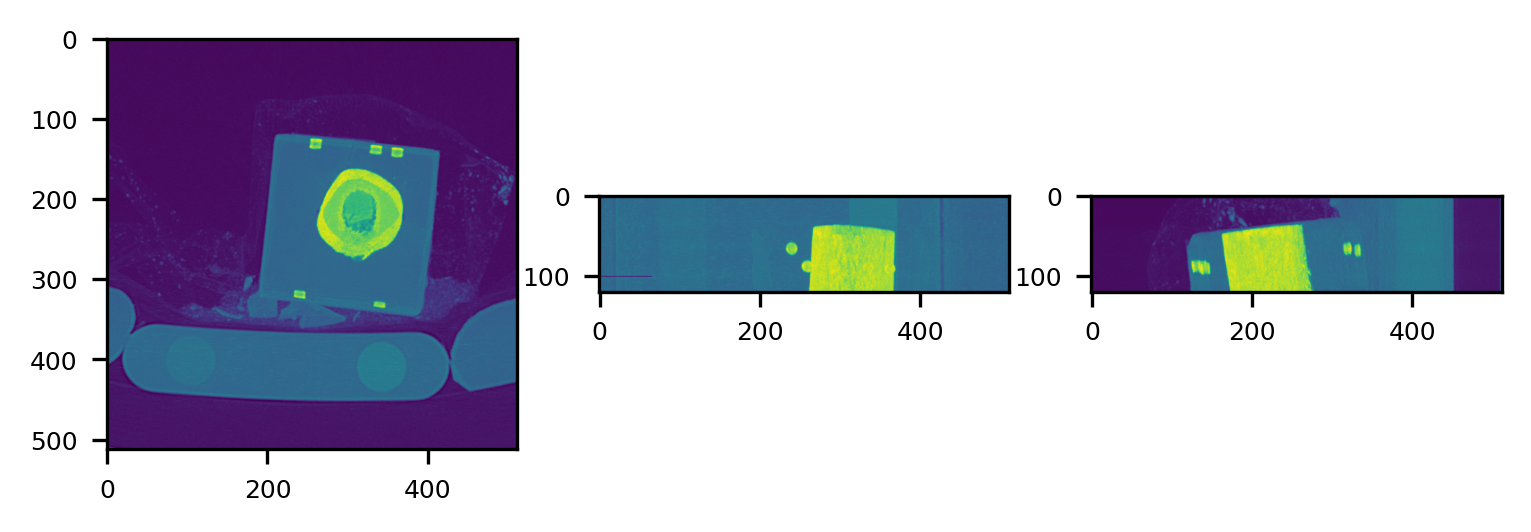

In [116]:
ru.plot_projections(data_3D_QCT[0:120,:,:])

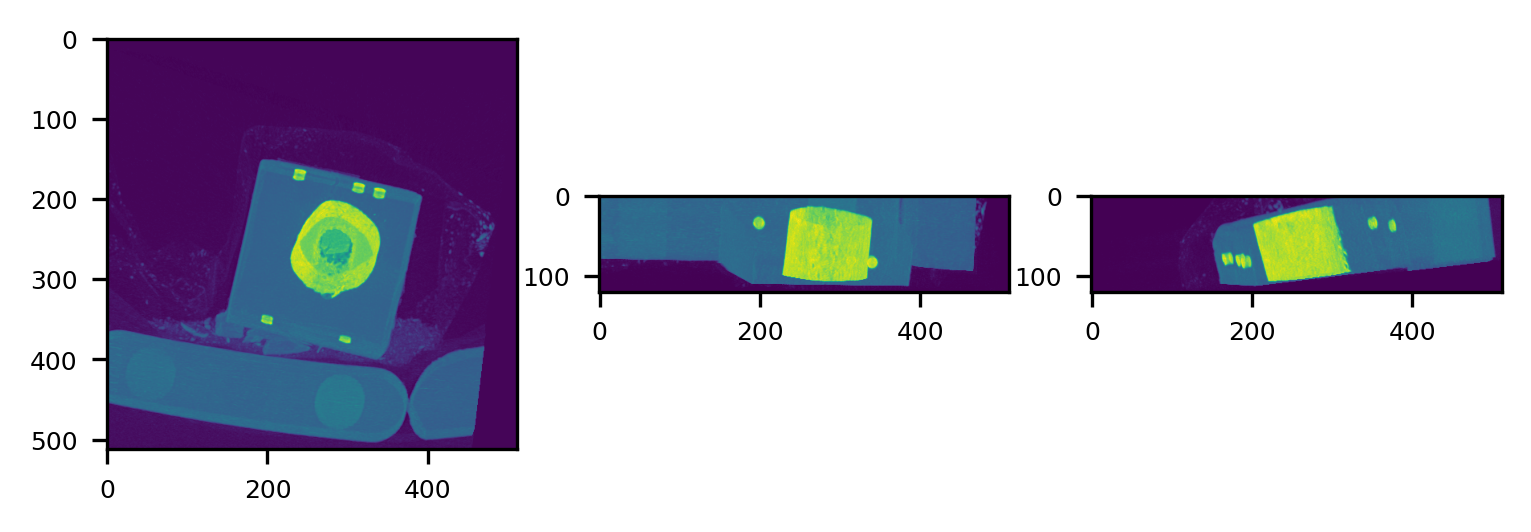

In [117]:
ru.plot_projections(sitk.GetArrayFromImage(img_trans))

In [ ]:
import itk
from itkwidgets import view
viewer = view(data_3D, ui_collapsed=True)
viewer.interpolation = False

In [ ]:
# launch itk viewer
viewer

### Thresholding

In [ ]:
# use Otsu's method
T = threshold_otsu(data_3D)
print("Threshold: {}".format(T))

In [ ]:
# plot the input image histogram
fig2, ax2 = plt.subplots()
plt.hist(data_3D.ravel(), bins=40)
plt.show()

In [ ]:
# apply the threshold
# BW = data_3D > T
BW = data_3D > 142

In [ ]:
# Inspect binary mask
plot_midplanes(BW)
plt.show()

### Whole bone mask (periosteum mask)

In [ ]:
BW_peri = pbm.periosteummask(BW, closepixels=8, closevoxels=10, remove_objects_smaller_than=1, removeunconn=True, verbose=True)

In [ ]:
# Inspect whole bone mask
plot_midplanes(BW_peri)
plt.show()

### Cortical and trabecular bone masks
Not implemented yet.. we erode the whole bone mask instead to obtain a tentative mesh of the trabecular core

In [ ]:
BW_trab = morphology.binary_erosion(BW_peri, morphology.cube(15))

In [ ]:
# Inspect mask
plot_midplanes(BW_trab.astype('int')+BW_peri.astype('int'))
plt.show()

In [ ]:
import napari
viewer = napari.view_image()

## Meshing
### Create tetrahedra mesh of trabecular core
Volume meshing is done using [CGAL](https://www.cgal.org/) through [pygalmesh](https://github.com/nschloe/pygalmesh)

In [ ]:
# min_facet_angle=20,  lloyd=True,
mesh_trab = pygalmesh.generate_from_array(np.transpose(BW_trab, [2, 1, 0]).astype('uint8'), tuple(vs), max_facet_distance=3*min(vs), max_cell_circumradius=10*min(vs))

Remove triangles

In [ ]:
mesh_trab.remove_lower_dimensional_cells()

Write VTK mesh with [meshio](https://github.com/nschloe/meshio)

In [ ]:
filename_mesh_out = '/home/gianthk/PycharmProjects/CT2FE/test_data/trabecular_bone/2000L_crop_imgaussfilt_101micron_uint8.vtk'

In [ ]:
mesh_trab.write(filename_mesh_out)

Read the mesh if you have already generated it and want to start the notebook from this point

In [ ]:
import meshio
mesh_trab = meshio.read(filename_mesh_out)

#### Get Barycenter of each cell

In [ ]:
# cells barycenter coordinates
cells_bary = np.sum(mesh_trab.points[mesh_trab.cells[0][1][:]], 1)/mesh_trab.points[mesh_trab.cells[0][1][:]].shape[1]

### Extract fabric tensor at cells barycenters
Run this section on high-resolution data!

| ver | runtime |
|-----|---------|
| `to01(ROIACF)>ACF_threshold` | 04:38<00:00, 51.14it/s |
| `envelope(to01andbinary(ROIACF, ACF_threshold))` | 04:15<00:00, 55.66it/s |

In [ ]:
# pyfabric ACF parameters
ROIsize = 40
ACF_threshold=0.33
ROIzoom=True
zoom_size=20
zoom_factor=2

In [ ]:
evecs, radii, evals, fabric_comp, DA = pf.fabric_pointset(data_3D, cells_bary/vs[0], ROIsize, ACF_threshold, ROIzoom, zoom_size, zoom_factor)

In [ ]:
radii

In [ ]:
radii = np.abs(radii)

Remove potential outliers based on the ellipsoid radii: \
any ellipsoid with a radius > `ROIsize/2` is suspicious and therefore we remove it

In [ ]:
radii[np.any(radii>ROIsize*zoom_factor/2, axis=1),:] = np.nan
# radii[np.any(radii<-ROIsize*zoom_factor/2, axis=1),:] = np.nan
# try zoom_size instead of ROIsize

Also ellipsoid radii < 1 voxel are meaningless

In [ ]:
radii[np.any(radii<1, axis=1),:] = np.nan
# radii[radii==0] = 0.001

Check histogram of local fabric ellipsoid radii 

In [ ]:
fig2, ax2 = plt.subplots()

plt.hist(radii[:,0].ravel(), alpha=0.3, bins=100, label='r1')
plt.hist(radii[:,1].ravel(), alpha=0.3, bins=100, label='r2')
plt.hist(radii[:,2].ravel(), alpha=0.3, bins=100, label='r3')
# plt.hist(radii.ravel(), alpha=0.4, bins=100)
plt.legend(loc='upper right')
plt.show()

#### Compute local Degree of Anisotropy (DA) as the ratio between major and minor ellipsoid axes

In [ ]:
DA = np.nanmax(radii, 1)/np.nanmin(radii, 1)

Take a look at the distribution of DA

In [ ]:
fig2, ax2 = plt.subplots()
plt.hist(DA.ravel(), bins=100, label='r1')
plt.show()

#### Compute ellipsoid tensor components from its eigenvectors and radii
Compute ellipsoid eigenvalues

In [ ]:
evals = 1/(radii**2)

Ellipsoid eigen-decomposition: get rank-2 symmetric ellipsoid tensor from evals and evecs <br/>
see: https://www.researchgate.net/publication/265500937_Visualization_of_3D_tensor_fields_derived_from_seismic_images \
Symmetric tensor components are expected to have the following order: **XX, YY, ZZ, XY, YZ, XZ**

In [ ]:
fabric_tens = np.ndarray(evecs.shape)
fabric_comp = np.ndarray([evecs.shape[0], 6])
for cell in range(0,evecs.shape[0]):
    fabric_tens[cell,:,:] = np.matmul(evecs[cell,:,:], np.matmul((evals[cell,:]*np.identity(3)), np.transpose(evecs[cell,:,:])))
    fabric_comp[cell,:] = fabric_tens[cell,[0, 1, 2, 0, 1, 0],[0, 1, 2, 1, 2, 2]]

In [ ]:
fabric_tens = np.ndarray(evecs.shape)
fabric_comp = np.ndarray([evecs.shape[0], 6])
for cell in range(0, evecs.shape[0]):
    fabric_tens[cell, :, :] = np.matmul(evecs[cell, :, :], np.matmul((evals[cell, :] * np.identity(3)), np.transpose(evecs[cell, :, :])))
    fabric_comp[cell, :] = fabric_tens[cell, [2, 1, 0, 1, 0, 0], [2, 1, 0, 2, 1, 2]]
    evecs[cell, :, :] = np.flipud(evecs[cell, :, :])

In [ ]:
evecs[2,:,:]

In [ ]:
evals[2,:]

In [ ]:
cell=8700
np.matmul(evecs[cell,:,:], np.matmul((evals[cell,:]*np.identity(3)), np.transpose(evecs[cell,:,:])))

In [ ]:
evals[2,:]*np.identity(3)

Attach fabric cell data

In [ ]:
mesh_trab.cell_data={'evec1': evecs[:,:,0], 'evec2': evecs[:,:,1], 'evec3': evecs[:,:,2], 'radii': radii, 'fabric': fabric_comp, 'DA': DA}

Rewrite mesh with fabric data

In [ ]:
filename_mesh_out = '/home/gianthk/PycharmProjects/CT2FE/test_data/trabecular_bone/2000L_crop_imgaussfilt_101micron_uint8_fabric.vtk'

In [ ]:
mesh_trab.write(filename_mesh_out)